# Draft the Hilbert transform-based denoising method for RVT calculation
The input data are `sub-01_ses-01` physio data from [ds003357](https://openneuro.org/datasets/ds003357/versions/1.0.0).

In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt

import numpy as np
from scipy import signal

In [2]:
# From https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html


def butter_bandpass(fs, lowcut=None, highcut=None, order=5):
    nyq = 0.5 * fs

    if (lowcut is not None) and (highcut is not None):
        low = lowcut / nyq
        high = highcut / nyq
        window = (low, high)
        btype = "bandpass"
    elif lowcut is not None:
        window = lowcut / nyq
        btype = "highpass"
    elif highcut is not None:
        window = highcut / nyq
        btype = "lowpass"
    elif (lowcut is None) and (highcut is None):
        raise ValueError("Either lowcut or highcut must be specified.")

    b, a = signal.butter(order, window, btype=btype)
    return b, a


def butter_bandpass_filter(data, fs, lowcut=None, highcut=None, order=1):
    b, a = butter_bandpass(fs, lowcut, highcut, order=order)
    y = signal.filtfilt(b, a, data)
    return y


# From complex-flow


def split_complex(complex_signal):
    """
    Split a complex-valued nifti image into magnitude and phase images.
    """
    real = complex_signal.real
    imag = complex_signal.imag
    mag = abs(complex_signal)
    phase = to_phase(real, imag)
    return mag, phase


def to_phase(real, imag):
    """
    Convert real and imaginary data to phase data.
    Equivalent to cmath.phase.
    https://www.eeweb.com/quizzes/convert-between-real-imaginary-and-magnitude-phase
    """
    phase = np.arctan2(imag, real)
    return phase

# From this lovely post: https://stackoverflow.com/a/6520696


def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


def interp_nans(y):
    nans, x = nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [3]:
data_file = "/Users/taylor/Downloads/sub-01-ses-01-func-sub-01_ses-01_task-rest_physio.tsv.gz"
meta_file = "/Users/taylor/Downloads/sub-01-ses-01-func-sub-01_ses-01_task-rest_physio.json"

with open(meta_file, "r") as fo:
    metadata = json.load(fo)
sampling_freq = metadata["SamplingFrequency"]

data = np.loadtxt(data_file)
resp = data[:, 0]


In [4]:
# Remove low frequency drifts (less than 0.01 Hz) from the breathing signal, 
# and remove high-frequency noise above 2.0 Hz.
# Lowpass filter the data again to more aggressively remove high-frequency noise above 0.75 Hz.
HPF, LPF = 0.01, 0.75
resp_filt = butter_bandpass_filter(resp, fs=sampling_freq, lowcut=HPF, highcut=LPF, order=1)

<ipython-input-5-644cad8cc246>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


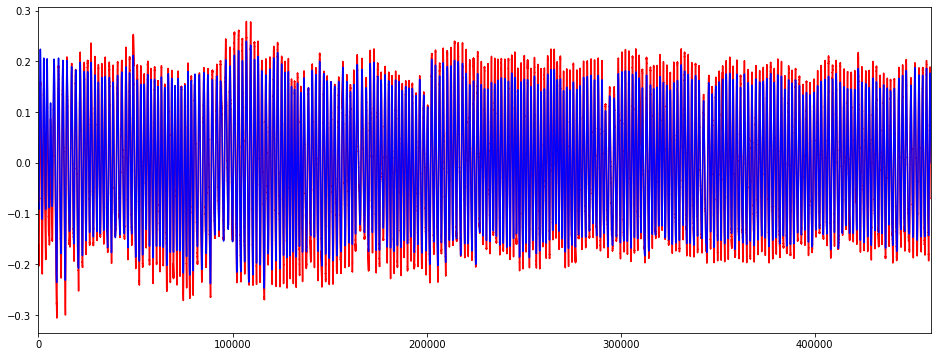

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))
temp_resp = resp - np.mean(resp)
ax.plot(temp_resp, color='red')
ax.plot(resp_filt, color='blue')
ax.set_xlim(0, len(resp) - 1)
fig.show()

In [6]:
# Decompose the signal into magnitude and phase components via the Hilbert transform.
hibby = signal.hilbert(resp_filt)
magn, phas = split_complex(hibby)

In [7]:
for i in range(10):
    # Linearly interpolate any periods where the phase time course decreases,
    # using the procedure in Figure 2, to remove any artefactual negative frequencies.
    bad_idx = phas < 0
    phas[bad_idx] = np.nan
    phas = interp_nans(phas)
    # Reconstruct the oscillatory portion of the signal, cos(𝜙(𝑡)), 
    # and lowpass filter at 0.75 Hz to remove any resulting artefacts.
    oscill = np.cos(phas)
    oscill = butter_bandpass_filter(oscill, fs=sampling_freq, highcut=0.75)
    phas = np.arccos(oscill)
    # This procedure is repeated 10 times, with the new phase timecourse
    # re-estimated from the filtered oscillatory signal.

In [8]:
# instantaneous breathing rate is temporal derivative of phase
# not sure why pi is here but it's in the preprint's formula
ibr = np.append(0, np.diff(phas)) / (2 * np.pi)

# respiratory volume is twice signal amplitude
rv = 2 * magn

# low-pass filter both(?) at 0.2Hz
ibr = butter_bandpass_filter(ibr, fs=sampling_freq, highcut=0.75)
rv = butter_bandpass_filter(rv, fs=sampling_freq, highcut=0.75)

# rvt is product of ibr and rv
rvt = ibr * rv

<ipython-input-9-998315bd33ad>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


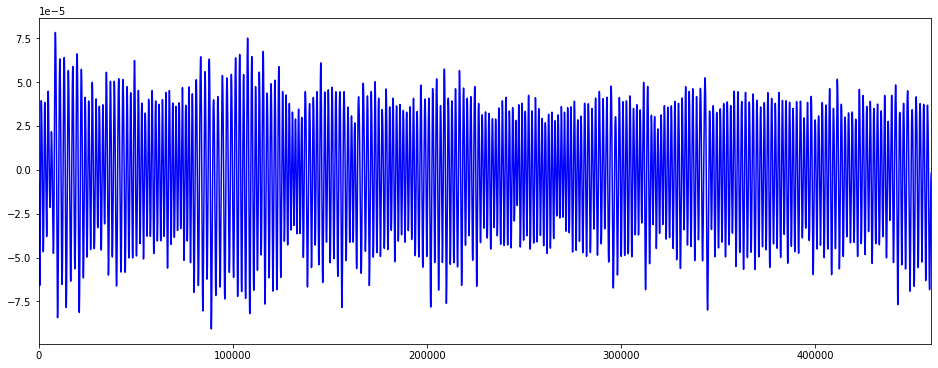

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(rvt, color='blue')
ax.set_xlim(0, len(resp) - 1)
fig.show()